In [1]:
import pandas as pd
import krippendorff
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats import inter_rater as irr
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

def agreement_calculation(df, name_columns):
    results = []

    for i in name_columns:
        results.append(list(df[i]))
    
    unique = list(set([x for xs in results for x in xs]))
    le = LabelEncoder()
    le.fit(unique)

    if(len(results) <= 2):

        encod_rater1 = le.transform(results[0])
        encod_rater2 = le.transform(results[1])
        kappa_cohen = cohen_kappa_score(encod_rater1, encod_rater2)

        print("Kappa Cohen: ", kappa_cohen, "\n")

    else:

        print("Kappa Cohen:  There are more than two annotators! In this case, use Kappa Fleiss or Krippendorff's Alpha.\n")

    encod_rater = []

    for i in range(len(results)):
        encod_rater.append(le.transform(results[i]))

    giro = np.array(encod_rater).transpose()
    kappa_fleiss = irr.fleiss_kappa(irr.aggregate_raters(giro)[0], method='fleiss')

    print("Kappa Fleiss: ", kappa_fleiss, "\n")

    alpha = krippendorff.alpha(reliability_data=results, level_of_measurement="nominal")

    print("Krippendorff's alpha for nominal metric: ", alpha, "\n")
    
    return kappa_cohen


def trainer_fixed_pipeline(df_train, df_test):
    vectorizer = CountVectorizer()
    features = vectorizer.fit_transform(df_train['full'])
    
    features_test = vectorizer.transform(df_test['full'])
    
    rf = RandomForestClassifier(n_estimators=10).fit(features, df_train['_entailment'])
    y_pred_rf = rf.predict(features_test)
    print("Classification report RF: \n", classification_report(df_test['_entailment'], y_pred_rf))
    
    knn = KNeighborsClassifier().fit(features, df_train['_entailment'])
    y_pred_knn = knn.predict(features_test)
    print("Classification report KNN: \n", classification_report(df_test['_entailment'], y_pred_knn))
    
    nb = MultinomialNB().fit(features.toarray(), df_train['_entailment'])
    y_pred_nb = nb.predict(features_test.toarray())
    print("Classification report NB: \n", classification_report(df_test['_entailment'], y_pred_nb))
    
    lr = LogisticRegression().fit(features, df_train['_entailment'])
    y_pred_lr = lr.predict(features_test)
    print("Classification report LR: \n", classification_report(df_test['_entailment'], y_pred_lr))
    
    return features, rf, y_pred_rf, knn, y_pred_knn, nb, y_pred_nb, lr, y_pred_lr

In [2]:
df_test = pd.read_csv('datasets/assin2/assin2-test.csv')
df_train = pd.read_csv('datasets/assin2/assin2-train-only.csv')

df_train = shuffle(df_train, random_state=20)

df_train['full'] = df_train['t'] + " " + df_train['h']
df_test['full'] = df_test['t'] + " " + df_test['h']

df_agreement = df_train.copy()
df_agreement.drop(columns=['t', 'h', '_id', '_similarity', 'full'], inplace=True)
df_agreement['rater'] = df_train['_entailment']
df_agreement_temp = df_agreement.copy()

name_columns = [
    '_entailment',
    'rater'
]
    
display(df_agreement)

,_entailment,rater
253,Entailment,Entailment
1188,Entailment,Entailment
5280,None,None
1063,Entailment,Entailment
6143,None,None
...,...,...
5910,None,None
3915,None,None
1428,Entailment,Entailment
4367,None,None


# Agreement 1.0

In [3]:
kappa_100 = agreement_calculation(df_agreement, name_columns)

if kappa_100 == 1:
    features100, rf100, y_pred_rf100, knn100, y_pred_knn100, nb100, y_pred_nb100, lr100, y_pred_lr100 = trainer_fixed_pipeline(df_train, df_test)

Kappa Cohen:  1.0 

Kappa Fleiss:  1.0 

Krippendorff's alpha for nominal metric:  1.0 

Classification report RF: 
               precision    recall  f1-score   support

  Entailment       0.62      0.92      0.74      1224
        None       0.85      0.43      0.57      1224

    accuracy                           0.68      2448
   macro avg       0.73      0.68      0.66      2448
weighted avg       0.73      0.68      0.66      2448

Classification report KNN: 
               precision    recall  f1-score   support

  Entailment       0.51      0.65      0.57      1224
        None       0.52      0.38      0.44      1224

    accuracy                           0.51      2448
   macro avg       0.51      0.51      0.50      2448
weighted avg       0.51      0.51      0.50      2448

Classification report NB: 
               precision    recall  f1-score   support

  Entailment       0.55      0.76      0.64      1224
        None       0.61      0.38      0.47      1224

    accu

# Agreement 0.90

In [4]:
df_agreement = df_agreement_temp.copy()

for i in range(300):
    if(df_agreement['rater'].iloc[i] == 'Entailment'):
        df_agreement['rater'].iloc[i] = 'None'
    else:
        df_agreement['rater'].iloc[i] = 'Entailment'

kappa_90 = agreement_calculation(df_agreement, name_columns)
df_train['_entailment'] = df_agreement['rater']

if (kappa_90 >= 0.88) and (kappa_90 <= 0.92):
    features90, rf90, y_pred_rf90, knn90, y_pred_knn90, nb90, y_pred_nb90, lr90, y_pred_lr90 = trainer_fixed_pipeline(df_train, df_test)

Kappa Cohen:  0.9076923076923077 

Kappa Fleiss:  0.9076894761079536 

Krippendorff's alpha for nominal metric:  0.9076965769174836 

Classification report RF: 
               precision    recall  f1-score   support

  Entailment       0.61      0.87      0.72      1224
        None       0.78      0.45      0.57      1224

    accuracy                           0.66      2448
   macro avg       0.70      0.66      0.65      2448
weighted avg       0.70      0.66      0.65      2448

Classification report KNN: 
               precision    recall  f1-score   support

  Entailment       0.51      0.63      0.57      1224
        None       0.52      0.40      0.45      1224

    accuracy                           0.52      2448
   macro avg       0.52      0.52      0.51      2448
weighted avg       0.52      0.52      0.51      2448

Classification report NB: 
               precision    recall  f1-score   support

  Entailment       0.54      0.75      0.63      1224
        None      

# Agreement 0.80

In [5]:
df_agreement = df_agreement_temp.copy()

for i in range(600):
    if(df_agreement['rater'].iloc[i] == 'Entailment'):
        df_agreement['rater'].iloc[i] = 'None'
    else:
        df_agreement['rater'].iloc[i] = 'Entailment'

kappa_80 = agreement_calculation(df_agreement, name_columns)
df_train['_entailment'] = df_agreement['rater']

if (kappa_80 >= 0.78) and (kappa_80 <= 0.82):
    features80, rf80, y_pred_rf80, knn80, y_pred_knn80, nb80, y_pred_nb80, lr80, y_pred_lr80 = trainer_fixed_pipeline(df_train, df_test)

Kappa Cohen:  0.8153846153846154 

Kappa Fleiss:  0.8153776237680007 

Krippendorff's alpha for nominal metric:  0.8153918254892493 

Classification report RF: 
               precision    recall  f1-score   support

  Entailment       0.62      0.85      0.72      1224
        None       0.76      0.48      0.59      1224

    accuracy                           0.66      2448
   macro avg       0.69      0.66      0.65      2448
weighted avg       0.69      0.66      0.65      2448

Classification report KNN: 
               precision    recall  f1-score   support

  Entailment       0.52      0.63      0.57      1224
        None       0.52      0.41      0.46      1224

    accuracy                           0.52      2448
   macro avg       0.52      0.52      0.51      2448
weighted avg       0.52      0.52      0.51      2448

Classification report NB: 
               precision    recall  f1-score   support

  Entailment       0.53      0.74      0.62      1224
        None      

# Agreement 0.70

In [6]:
df_agreement = df_agreement_temp.copy()

for i in range(950):
    if(df_agreement['rater'].iloc[i] == 'Entailment'):
        df_agreement['rater'].iloc[i] = 'None'
    else:
        df_agreement['rater'].iloc[i] = 'Entailment'

kappa_70 = agreement_calculation(df_agreement, name_columns)
df_train['_entailment'] = df_agreement['rater']

if (kappa_70 >= 0.68) and (kappa_70 <= 0.72):
    features70, rf70, y_pred_rf70, knn70, y_pred_knn70, nb70, y_pred_nb70, lr70, y_pred_lr70 = trainer_fixed_pipeline(df_train, df_test)

Kappa Cohen:  0.7076923076923076 

Kappa Fleiss:  0.7076883225674271 

Krippendorff's alpha for nominal metric:  0.7077108080810759 

Classification report RF: 
               precision    recall  f1-score   support

  Entailment       0.60      0.83      0.69      1224
        None       0.72      0.44      0.55      1224

    accuracy                           0.63      2448
   macro avg       0.66      0.63      0.62      2448
weighted avg       0.66      0.63      0.62      2448

Classification report KNN: 
               precision    recall  f1-score   support

  Entailment       0.52      0.63      0.57      1224
        None       0.53      0.42      0.47      1224

    accuracy                           0.53      2448
   macro avg       0.53      0.53      0.52      2448
weighted avg       0.53      0.53      0.52      2448

Classification report NB: 
               precision    recall  f1-score   support

  Entailment       0.53      0.74      0.62      1224
        None      

# Agreement 0.60

In [7]:
df_agreement = df_agreement_temp.copy()

for i in range(1300):
    if(df_agreement['rater'].iloc[i] == 'Entailment'):
        df_agreement['rater'].iloc[i] = 'None'
    else:
        df_agreement['rater'].iloc[i] = 'Entailment'

kappa_60 = agreement_calculation(df_agreement, name_columns)
df_train['_entailment'] = df_agreement['rater']

if (kappa_60 >= 0.58) and (kappa_60 <= 0.62):
    features60, rf60, y_pred_rf60, knn60, y_pred_knn60, nb60, y_pred_nb60, lr60, y_pred_lr60 = trainer_fixed_pipeline(df_train, df_test)

Kappa Cohen:  0.6 

Kappa Fleiss:  0.5999996591713073 

Krippendorff's alpha for nominal metric:  0.600030428428294 

Classification report RF: 
               precision    recall  f1-score   support

  Entailment       0.60      0.80      0.68      1224
        None       0.69      0.46      0.55      1224

    accuracy                           0.63      2448
   macro avg       0.64      0.63      0.62      2448
weighted avg       0.64      0.63      0.62      2448

Classification report KNN: 
               precision    recall  f1-score   support

  Entailment       0.52      0.62      0.57      1224
        None       0.53      0.43      0.47      1224

    accuracy                           0.52      2448
   macro avg       0.52      0.52      0.52      2448
weighted avg       0.52      0.52      0.52      2448

Classification report NB: 
               precision    recall  f1-score   support

  Entailment       0.53      0.72      0.61      1224
        None       0.56      0.36 

# Agreement 0.50

In [8]:
df_agreement = df_agreement_temp.copy()

for i in range(1600):
    if(df_agreement['rater'].iloc[i] == 'Entailment'):
        df_agreement['rater'].iloc[i] = 'None'
    else:
        df_agreement['rater'].iloc[i] = 'Entailment'

kappa_50 = agreement_calculation(df_agreement, name_columns)
df_train['_entailment'] = df_agreement['rater']

if (kappa_50 >= 0.48) and (kappa_50 <= 0.52):
    features50, rf50, y_pred_rf50, knn50, y_pred_knn50, nb50, y_pred_nb50, lr50, y_pred_lr50 = trainer_fixed_pipeline(df_train, df_test)

Kappa Cohen:  0.5076923076923077 

Kappa Fleiss:  0.5076918882108395 

Krippendorff's alpha for nominal metric:  0.5077297580655926 

Classification report RF: 
               precision    recall  f1-score   support

  Entailment       0.59      0.75      0.66      1224
        None       0.66      0.48      0.56      1224

    accuracy                           0.62      2448
   macro avg       0.63      0.62      0.61      2448
weighted avg       0.63      0.62      0.61      2448

Classification report KNN: 
               precision    recall  f1-score   support

  Entailment       0.51      0.59      0.55      1224
        None       0.52      0.44      0.47      1224

    accuracy                           0.52      2448
   macro avg       0.52      0.52      0.51      2448
weighted avg       0.52      0.52      0.51      2448

Classification report NB: 
               precision    recall  f1-score   support

  Entailment       0.53      0.73      0.62      1224
        None      

# Agreement 0.40

In [9]:
df_agreement = df_agreement_temp.copy()

for i in range(2000):
    if(df_agreement['rater'].iloc[i] == 'Entailment'):
        df_agreement['rater'].iloc[i] = 'None'
    else:
        df_agreement['rater'].iloc[i] = 'Entailment'

kappa_40 = agreement_calculation(df_agreement, name_columns)
df_train['_entailment'] = df_agreement['rater']

if (kappa_40 >= 0.38) and (kappa_40 <= 0.42):
    features40, rf40, y_pred_rf40, knn40, y_pred_knn40, nb40, y_pred_nb40, lr40, y_pred_lr40 = trainer_fixed_pipeline(df_train, df_test)

Kappa Cohen:  0.3846153846153846 

Kappa Fleiss:  0.3846153846153846 

Krippendorff's alpha for nominal metric:  0.38466272189349116 

Classification report RF: 
               precision    recall  f1-score   support

  Entailment       0.57      0.68      0.62      1224
        None       0.61      0.50      0.55      1224

    accuracy                           0.59      2448
   macro avg       0.59      0.59      0.58      2448
weighted avg       0.59      0.59      0.58      2448

Classification report KNN: 
               precision    recall  f1-score   support

  Entailment       0.50      0.57      0.53      1224
        None       0.50      0.44      0.47      1224

    accuracy                           0.50      2448
   macro avg       0.50      0.50      0.50      2448
weighted avg       0.50      0.50      0.50      2448

Classification report NB: 
               precision    recall  f1-score   support

  Entailment       0.52      0.67      0.59      1224
        None     

# Agreement 0.30

In [10]:
df_agreement = df_agreement_temp.copy()

for i in range(2300):
    if(df_agreement['rater'].iloc[i] == 'Entailment'):
        df_agreement['rater'].iloc[i] = 'None'
    else:
        df_agreement['rater'].iloc[i] = 'Entailment'

kappa_30 = agreement_calculation(df_agreement, name_columns)
df_train['_entailment'] = df_agreement['rater']

if (kappa_30 >= 0.28) and (kappa_30 <= 0.32):
    features30, rf30, y_pred_rf30, knn30, y_pred_knn30, nb30, y_pred_nb30, lr30, y_pred_lr30 = trainer_fixed_pipeline(df_train, df_test)

Kappa Cohen:  0.29230769230769227 

Kappa Fleiss:  0.29230601729234873 

Krippendorff's alpha for nominal metric:  0.2923604552910184 

Classification report RF: 
               precision    recall  f1-score   support

  Entailment       0.57      0.68      0.62      1224
        None       0.60      0.48      0.53      1224

    accuracy                           0.58      2448
   macro avg       0.58      0.58      0.58      2448
weighted avg       0.58      0.58      0.58      2448

Classification report KNN: 
               precision    recall  f1-score   support

  Entailment       0.50      0.55      0.53      1224
        None       0.50      0.45      0.47      1224

    accuracy                           0.50      2448
   macro avg       0.50      0.50      0.50      2448
weighted avg       0.50      0.50      0.50      2448

Classification report NB: 
               precision    recall  f1-score   support

  Entailment       0.53      0.67      0.59      1224
        None    

# Agreement 0.20

In [11]:
df_agreement = df_agreement_temp.copy()

for i in range(2600):
    if(df_agreement['rater'].iloc[i] == 'Entailment'):
        df_agreement['rater'].iloc[i] = 'None'
    else:
        df_agreement['rater'].iloc[i] = 'Entailment'

kappa_20 = agreement_calculation(df_agreement, name_columns)
df_train['_entailment'] = df_agreement['rater']

if (kappa_20 >= 0.18) and (kappa_20 <= 0.22):
    features20, rf20, y_pred_rf20, knn20, y_pred_knn20, nb20, y_pred_nb20, lr20, y_pred_lr20 = trainer_fixed_pipeline(df_train, df_test)

Kappa Cohen:  0.19999999999999996 

Kappa Fleiss:  0.19999931834261436 

Krippendorff's alpha for nominal metric:  0.20006085685658803 

Classification report RF: 
               precision    recall  f1-score   support

  Entailment       0.54      0.61      0.58      1224
        None       0.56      0.48      0.52      1224

    accuracy                           0.55      2448
   macro avg       0.55      0.55      0.55      2448
weighted avg       0.55      0.55      0.55      2448

Classification report KNN: 
               precision    recall  f1-score   support

  Entailment       0.50      0.54      0.52      1224
        None       0.50      0.46      0.48      1224

    accuracy                           0.50      2448
   macro avg       0.50      0.50      0.50      2448
weighted avg       0.50      0.50      0.50      2448

Classification report NB: 
               precision    recall  f1-score   support

  Entailment       0.53      0.63      0.57      1224
        None   

# Agreement 0.10

In [12]:
df_agreement = df_agreement_temp.copy()

for i in range(2900):
    if(df_agreement['rater'].iloc[i] == 'Entailment'):
        df_agreement['rater'].iloc[i] = 'None'
    else:
        df_agreement['rater'].iloc[i] = 'Entailment'

kappa_10 = agreement_calculation(df_agreement, name_columns)
df_train['_entailment'] = df_agreement['rater']

if (kappa_10 >= 0.08) and (kappa_10 <= 0.12):
    features10, rf10, y_pred_rf10, knn10, y_pred_knn10, nb10, y_pred_nb10, lr10, y_pred_lr10 = trainer_fixed_pipeline(df_train, df_test)

Kappa Cohen:  0.10769230769230764 

Kappa Fleiss:  0.10769196977684055 

Krippendorff's alpha for nominal metric:  0.10776060885608862 

Classification report RF: 
               precision    recall  f1-score   support

  Entailment       0.50      0.54      0.52      1224
        None       0.50      0.46      0.48      1224

    accuracy                           0.50      2448
   macro avg       0.50      0.50      0.50      2448
weighted avg       0.50      0.50      0.50      2448

Classification report KNN: 
               precision    recall  f1-score   support

  Entailment       0.49      0.52      0.51      1224
        None       0.49      0.46      0.47      1224

    accuracy                           0.49      2448
   macro avg       0.49      0.49      0.49      2448
weighted avg       0.49      0.49      0.49      2448

Classification report NB: 
               precision    recall  f1-score   support

  Entailment       0.50      0.55      0.53      1224
        None   

# Agreement 0.00

In [13]:
df_agreement = df_agreement_temp.copy()

for i in range(3200):
    if(df_agreement['rater'].iloc[i] == 'Entailment'):
        df_agreement['rater'].iloc[i] = 'None'
    else:
        df_agreement['rater'].iloc[i] = 'Entailment'

kappa_0 = agreement_calculation(df_agreement, name_columns)
df_train['_entailment'] = df_agreement['rater']

if kappa_0 <= 0.02:
    features0, rf0, y_pred_rf0, knn0, y_pred_knn0, nb0, y_pred_nb0, lr0, y_pred_lr0 = trainer_fixed_pipeline(df_train, df_test)

Kappa Cohen:  0.01538461538461533 

Kappa Fleiss:  0.015384242512375662 

Krippendorff's alpha for nominal metric:  0.015459982186028842 

Classification report RF: 
               precision    recall  f1-score   support

  Entailment       0.48      0.49      0.48      1224
        None       0.47      0.46      0.47      1224

    accuracy                           0.48      2448
   macro avg       0.48      0.48      0.48      2448
weighted avg       0.48      0.48      0.48      2448

Classification report KNN: 
               precision    recall  f1-score   support

  Entailment       0.49      0.49      0.49      1224
        None       0.49      0.48      0.49      1224

    accuracy                           0.49      2448
   macro avg       0.49      0.49      0.49      2448
weighted avg       0.49      0.49      0.49      2448

Classification report NB: 
               precision    recall  f1-score   support

  Entailment       0.48      0.49      0.48      1224
        None 

# Disagreement

In [14]:
df_agreement = df_agreement_temp.copy()

for i in range(len(df_agreement)):
    if(df_agreement['rater'].iloc[i] == 'Entailment'):
        df_agreement['rater'].iloc[i] = 'None'
    else:
        df_agreement['rater'].iloc[i] = 'Entailment'

kappa_00 = agreement_calculation(df_agreement, name_columns)
df_train['_entailment'] = df_agreement['rater']

if kappa_00 <= 0.02:
    features00, rf00, y_pred_rf00, knn00, y_pred_knn00, nb00, y_pred_nb00, lr00, y_pred_lr00 = trainer_fixed_pipeline(df_train, df_test)

Kappa Cohen:  -1.0 

Kappa Fleiss:  -1.0 

Krippendorff's alpha for nominal metric:  -0.9998461538461538 

Classification report RF: 
               precision    recall  f1-score   support

  Entailment       0.19      0.11      0.14      1224
        None       0.36      0.51      0.43      1224

    accuracy                           0.31      2448
   macro avg       0.28      0.31      0.28      2448
weighted avg       0.28      0.31      0.28      2448

Classification report KNN: 
               precision    recall  f1-score   support

  Entailment       0.48      0.35      0.41      1224
        None       0.49      0.62      0.55      1224

    accuracy                           0.49      2448
   macro avg       0.49      0.49      0.48      2448
weighted avg       0.49      0.49      0.48      2448

Classification report NB: 
               precision    recall  f1-score   support

  Entailment       0.39      0.24      0.29      1224
        None       0.45      0.62      0.52  

# Comparison of metrics

In [15]:
df_ytest = df_test['_entailment']

agreements = ['< 0', 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [16]:
from sklearn.metrics import f1_score

rf_f1_100 = f1_score(df_ytest, y_pred_rf100, average='macro')
rf_f1_90 = f1_score(df_ytest, y_pred_rf90, average='macro')
rf_f1_80 = f1_score(df_ytest, y_pred_rf80, average='macro')
rf_f1_70 = f1_score(df_ytest, y_pred_rf70, average='macro')
rf_f1_60 = f1_score(df_ytest, y_pred_rf60, average='macro')
rf_f1_50 = f1_score(df_ytest, y_pred_rf50, average='macro')
rf_f1_40 = f1_score(df_ytest, y_pred_rf40, average='macro')
rf_f1_30 = f1_score(df_ytest, y_pred_rf30, average='macro')
rf_f1_20 = f1_score(df_ytest, y_pred_rf20, average='macro')
rf_f1_10 = f1_score(df_ytest, y_pred_rf10, average='macro')
rf_f1_0 = f1_score(df_ytest, y_pred_rf0, average='macro')
rf_f1_00 = f1_score(df_ytest, y_pred_rf00, average='macro')

rf_f1 = [rf_f1_100, rf_f1_90, rf_f1_80, rf_f1_70, rf_f1_60, rf_f1_50, rf_f1_40, rf_f1_30, rf_f1_20, 
         rf_f1_10, rf_f1_0, rf_f1_00]

rf_f1 = rf_f1[::-1]

In [17]:
from sklearn.metrics import f1_score

knn_f1_100 = f1_score(df_ytest, y_pred_knn100, average='macro')
knn_f1_90 = f1_score(df_ytest, y_pred_knn90, average='macro')
knn_f1_80 = f1_score(df_ytest, y_pred_knn80, average='macro')
knn_f1_70 = f1_score(df_ytest, y_pred_knn70, average='macro')
knn_f1_60 = f1_score(df_ytest, y_pred_knn60, average='macro')
knn_f1_50 = f1_score(df_ytest, y_pred_knn50, average='macro')
knn_f1_40 = f1_score(df_ytest, y_pred_knn40, average='macro')
knn_f1_30 = f1_score(df_ytest, y_pred_knn30, average='macro')
knn_f1_20 = f1_score(df_ytest, y_pred_knn20, average='macro')
knn_f1_10 = f1_score(df_ytest, y_pred_knn10, average='macro')
knn_f1_0 = f1_score(df_ytest, y_pred_knn0, average='macro')
knn_f1_00 = f1_score(df_ytest, y_pred_knn00, average='macro')

knn_f1 = [knn_f1_100, knn_f1_90, knn_f1_80, knn_f1_70, knn_f1_60, knn_f1_50, knn_f1_40, knn_f1_30, knn_f1_20, 
         knn_f1_10, knn_f1_0, knn_f1_00]

knn_f1 = knn_f1[::-1]

In [18]:
from sklearn.metrics import f1_score

nb_f1_100 = f1_score(df_ytest, y_pred_nb100, average='macro')
nb_f1_90 = f1_score(df_ytest, y_pred_nb90, average='macro')
nb_f1_80 = f1_score(df_ytest, y_pred_nb80, average='macro')
nb_f1_70 = f1_score(df_ytest, y_pred_nb70, average='macro')
nb_f1_60 = f1_score(df_ytest, y_pred_nb60, average='macro')
nb_f1_50 = f1_score(df_ytest, y_pred_nb50, average='macro')
nb_f1_40 = f1_score(df_ytest, y_pred_nb40, average='macro')
nb_f1_30 = f1_score(df_ytest, y_pred_nb30, average='macro')
nb_f1_20 = f1_score(df_ytest, y_pred_nb20, average='macro')
nb_f1_10 = f1_score(df_ytest, y_pred_nb10, average='macro')
nb_f1_0 = f1_score(df_ytest, y_pred_nb0, average='macro')
nb_f1_00 = f1_score(df_ytest, y_pred_nb00, average='macro')

nb_f1 = [nb_f1_100, nb_f1_90, nb_f1_80, nb_f1_70, nb_f1_60, nb_f1_50, nb_f1_40, nb_f1_30, nb_f1_20, 
         nb_f1_10, nb_f1_0, nb_f1_00]

nb_f1 = nb_f1[::-1]

In [19]:
from sklearn.metrics import f1_score

lr_f1_100 = f1_score(df_ytest, y_pred_lr100, average='macro')
lr_f1_90 = f1_score(df_ytest, y_pred_lr90, average='macro')
lr_f1_80 = f1_score(df_ytest, y_pred_lr80, average='macro')
lr_f1_70 = f1_score(df_ytest, y_pred_lr70, average='macro')
lr_f1_60 = f1_score(df_ytest, y_pred_lr60, average='macro')
lr_f1_50 = f1_score(df_ytest, y_pred_lr50, average='macro')
lr_f1_40 = f1_score(df_ytest, y_pred_lr40, average='macro')
lr_f1_30 = f1_score(df_ytest, y_pred_lr30, average='macro')
lr_f1_20 = f1_score(df_ytest, y_pred_lr20, average='macro')
lr_f1_10 = f1_score(df_ytest, y_pred_lr10, average='macro')
lr_f1_0 = f1_score(df_ytest, y_pred_lr0, average='macro')
lr_f1_00 = f1_score(df_ytest, y_pred_lr00, average='macro')

lr_f1 = [lr_f1_100, lr_f1_90, lr_f1_80, lr_f1_70, lr_f1_60, lr_f1_50, lr_f1_40, lr_f1_30, lr_f1_20, 
         lr_f1_10, lr_f1_0, lr_f1_00]

lr_f1 = lr_f1[::-1]

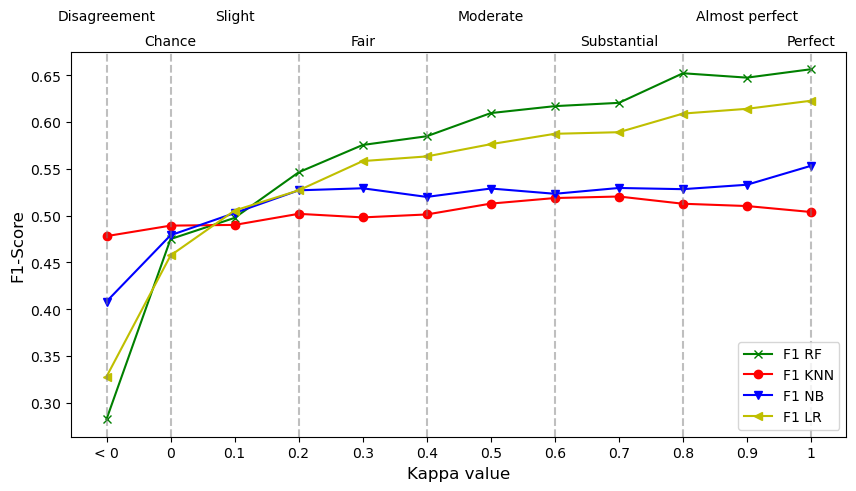

In [21]:
# Plot a simple line chart
plt.plot(agreements, rf_f1, 'g', label='F1 RF', marker='x')
plt.plot(agreements, knn_f1, 'r', label='F1 KNN', marker='o')
plt.plot(agreements, nb_f1, 'b', label='F1 NB', marker='v')
plt.plot(agreements, lr_f1, 'y', label='F1 LR', marker='<')

plt.axvline(x=0, linestyle='dashed', color='gray', alpha=0.5)
plt.axvline(x=1, linestyle='dashed', color='gray', alpha=0.5)
plt.axvline(x=3, linestyle='dashed', color='gray', alpha=0.5)
plt.axvline(x=5, linestyle='dashed', color='gray', alpha=0.5)
plt.axvline(x=7, linestyle='dashed', color='gray', alpha=0.5)
plt.axvline(x=9, linestyle='dashed', color='gray', alpha=0.5)
plt.axvline(x=11, linestyle='dashed', color='gray', alpha=0.5)

y_pos = plt.ylim()[1]

plt.text(0, y_pos * 1.05, 'Disagreement', color='black', ha='center')
plt.text(1, y_pos * 1.01, 'Chance', color='black', ha='center')
plt.text(2, y_pos * 1.05, 'Slight', color='black', ha='center')
plt.text(4, y_pos * 1.01, 'Fair', color='black', ha='center')
plt.text(6, y_pos * 1.05, 'Moderate', color='black', ha='center')
plt.text(8, y_pos * 1.01, 'Substantial', color='black', ha='center')
plt.text(10, y_pos * 1.05, 'Almost perfect', color='black', ha='center')
plt.text(11, y_pos * 1.01, 'Perfect', color='black', ha='center')

plt.legend()
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams.update({'font.size': 10})

plt.xlabel('Kappa value', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)

plt.show()